## Machine Learning - Lab 1

Alan Abazic, John Girard, Eric Laigaie, and Garrett Shankel

# Business Understanding

Our data is selected from user submitted ratings on AirBnB listings in the NYC area. AirBnB hosts are scored by their tenants across multiple categories. Categories can include the location, dollar value, check in easiness, cleanliness of the rental, or even the accuracy of the posting. This greatly benefits both the renter and AirBnB. From a renters perspective: they are able to trust the validity of postings and the hosts as they use the site. From AirBnB’s business perspective, crowd sourcing their due diligence allows for employees to put issues as they appear, while leaving renters and hosts who are satisfied alone.

Crowdsourced data is not as easy to work with as it lets on. It is simply only as good as the quality and quantity of the user/reviewer. Giving an honest review is often swayed by either a positive or negative experience, or in this case on a 0-10 basis, a 10 or 0 score respectively. Our model should be able to establish and predict a way to determine the accuracy of the review at above a 60% rating.

Price is something else we want to accurately predict. “How can an owner justify the cost of their listing”, are there certain amenities that justify a pricier listing? Understanding how these attributes interact with our response variable, price, is going to be the focal point of our second model. Our pricing model should be able to establish a relationship between the price of a listing and what attributes can justify a higher price of a rental. We would like this model to be at least 75% accurate.

# Data Meaning Type

Our data has 35 attributes across 75749 instances. Each instance refers to 1 rental property listing. Our group would inevitably exclude some of the attributes such as “name’, “host name”, “calendar last scraped”, and “last review date”. These fields proved to be non useful.

The way this data is collected and aggregated was an interesting process to our group: When a rental property owner registers their property on the application, they are filling in a lot of these attributes themselves. However, the “rating” attributes of the property itself is determined by the renter, or the end-user. Having these attributes be populated by many people to reach an aggregate gives a honest insight into the quality of both the rental and the host.

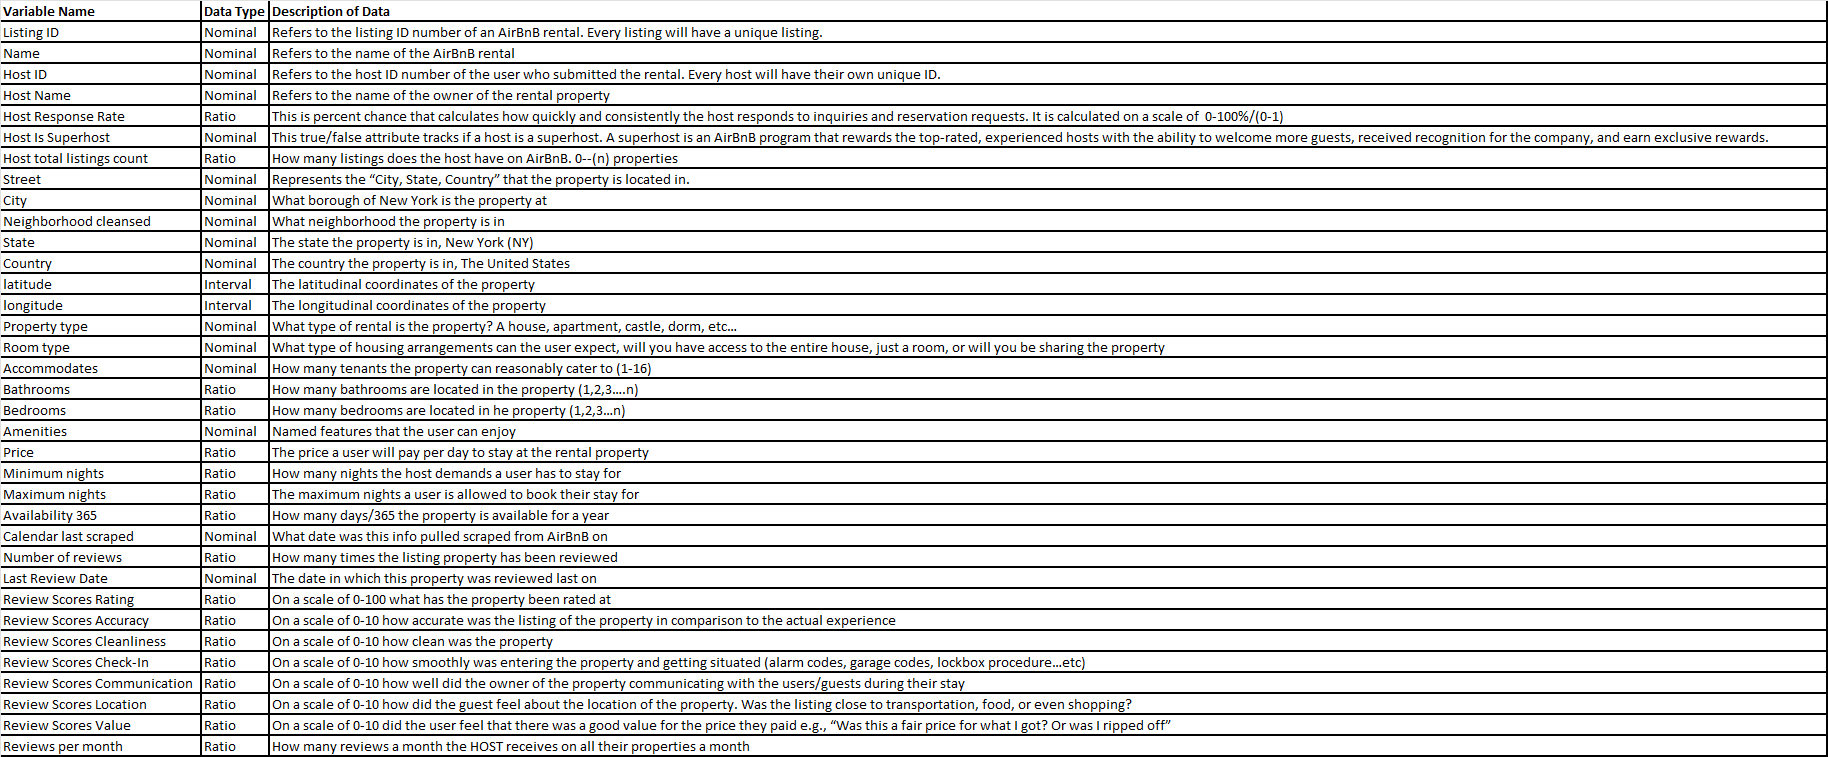

# Data Quality

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("NY_Listings.csv")

C:\Users\ericl\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7,19,24) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Missing Values

First, we need to examine all missing values in the dataset. Below is a complete run-through of missing values and the techniques used to clean up the dataset.

In [2]:
len(df)

75749

75,749 rows leaves us plenty of wiggle room. Down below, you'll find a summary of null values.

In [3]:
df.isnull().sum()

Listing ID                         0
Name                              31
Host ID                            0
Host Name                        232
Host Response Rate             45118
Host Is Superhost                  0
Host total listings count        232
Street                         31439
City                               0
Neighbourhood cleansed             0
State                              0
Country                            0
latitude                           0
longitude                          0
Property type                      0
Room type                          0
Accommodates                   31439
Bathrooms                      31581
Bedrooms                       31439
Amenities                      31721
Price                              0
Minimum nights                     0
Maximum nights                 31439
Availability 365                   0
Calendar last scraped          31439
Number of reviews                  0
Last Review Date               16683
R

#### Removing unwanted columns

As you can see above, there's a concerning amount of null values. However, some of these columns are not important for our goals. These include Name, Host Name, Calendar last scraped, and Last Review Date. These columns could provide some information, but overall, I'm okay to exclude them from any work we do - especially since the text columns won't give us anything unless we do some language processing.

These columns will be entirely removed from this dataset.

In [4]:
columnsToRemove = ["Name", "Host Name", "Calendar last scraped", "Last Review Date"]

df2 = df.drop(columns = columnsToRemove, axis=1)

df2.isnull().sum()

Listing ID                         0
Host ID                            0
Host Response Rate             45118
Host Is Superhost                  0
Host total listings count        232
Street                         31439
City                               0
Neighbourhood cleansed             0
State                              0
Country                            0
latitude                           0
longitude                          0
Property type                      0
Room type                          0
Accommodates                   31439
Bathrooms                      31581
Bedrooms                       31439
Amenities                      31721
Price                              0
Minimum nights                     0
Maximum nights                 31439
Availability 365                   0
Number of reviews                  0
Review Scores Rating               0
Review Scores Accuracy             0
Review Scores Cleanliness          0
Review Scores Checkin              0
R

#### Inspecting Rows with Multiple Columns Missing

Here, we've narrowed down the nulls a good amount. Now, lets try removing the rows where Street is null. I have a suspicion that all the columns with 31,439 nulls are missing the same rows. We could try to impute these values, but I fear that columns like Accommodates and Bedrooms are too important to guess on.

In [5]:
df3 = df2[df2['Street'].notnull()]

df3.isnull().sum()

Listing ID                         0
Host ID                            0
Host Response Rate             13679
Host Is Superhost                  0
Host total listings count        232
Street                             0
City                               0
Neighbourhood cleansed             0
State                              0
Country                            0
latitude                           0
longitude                          0
Property type                      0
Room type                          0
Accommodates                       0
Bathrooms                        142
Bedrooms                           0
Amenities                        282
Price                              0
Minimum nights                     0
Maximum nights                     0
Availability 365                   0
Number of reviews                  0
Review Scores Rating               0
Review Scores Accuracy             0
Review Scores Cleanliness          0
Review Scores Checkin              0
R

In [6]:
len(df3)

44310

Above, we can see that removing Street eliminated many null values. After more investigation, we found that columns with Null Street values were actually empty rows with only zeroes and nulls. While this is simply a hypothesis, these rows may pertain to rentals that were originally listed on Airbnb by their host, but listing was abandoned before the listing was complete.

#### Last four columns
Now that we're down to just four columns to look at, I'll take them one-by-one.

##### Bathrooms

For Bathrooms, these 142 columns only represent .3% of the dataset. I think if we partition out by room type and property type, we can impute the means.

In [7]:
bathroomsIncluded = df3[df3['Bathrooms'].notnull()]
bathroomsMissing = df3[df3['Bathrooms'].isna()]

df4 = df3[["Property type", "Room type", "Bathrooms"]]
df4 = df4[(df4["Property type"].isin(bathroomsMissing["Property type"].unique()))]
df4.groupby(by=["Property type", "Room type"]).mean()

Bathrooms
Property type   Room type                 
Apartment       Entire home/apt   1.099828
                Private room      1.096143
                Shared room       1.082711
Bed & Breakfast Entire home/apt   1.187500
                Private room      1.182692
                Shared room       1.000000
House           Entire home/apt   1.646916
                Private room      1.195214
                Shared room       1.692708

In [8]:
# For these values, I feel comfortable assigning 1 to all groups except for House:Entire and House:Shared.
# Those two groups will have 2 imputed.

bathroomsOne = bathroomsMissing[(bathroomsMissing['Property type'].isin(['Apartment', 'Bed & Breakfast'])) | 
                                (bathroomsMissing['Property type'] == 'House') &
                                (bathroomsMissing['Room type'] == 'Private room')]

bathroomsTwo = bathroomsMissing[(bathroomsMissing['Property type'] == 'House') &
                               (bathroomsMissing['Room type'] != 'Private room')]


bathroomsOne.loc[:, "Bathrooms"] = 1
bathroomsTwo.loc[:, "Bathrooms"] = 2

df5 = pd.concat([bathroomsIncluded, bathroomsOne, bathroomsTwo], ignore_index=True, axis=0)

#df5.isnull().sum()

C:\Users\ericl\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


##### Amenities

Since this column is formatted as a list of values, there isn't an easy process to impute these values. Since this is only .05% of the data, we will just remove these rows.

In [9]:
df6 = df5[df5['Amenities'].notnull()]
#df6.isnull().sum()

#### Host Response Rate

I think this column is fairly important to predicting rating / price. Therefore, we can't just remove these rows. First, we can check for an overlap of hosts with included and missing values. For those that don't match - we will just impute the median.

In [10]:
responseIncluded = df6[df6['Host Response Rate'].notnull()]
responseMissing = df6[df6['Host Response Rate'].isna()]

responseIncluded_small = responseIncluded[["Host ID", "Host Response Rate"]]
responseMissing_small = responseMissing[["Host ID", "Host Response Rate"]]

responseMatches = pd.merge(left = responseIncluded_small, right = responseMissing_small, on="Host ID", how="inner")

responseMatches

,Host ID,Host Response Rate_x,Host Response Rate_y


In [11]:
responseMissing.loc[:, "Host Response Rate"] = responseIncluded["Host Response Rate"].median()

df7 = pd.concat([responseIncluded, responseMissing], ignore_index=True, axis=0)

#df7.isnull().sum()

C:\Users\ericl\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


#### Host total listings count

We will handle this column the same way we handled Host Response Rate. Check for matches and impute the mean for those that do not match.

In [12]:
listingsIncluded = df7[df7['Host total listings count'].notnull()]
listingsMissing = df7[df7['Host total listings count'].isna()]

listingsIncluded_small = listingsIncluded[["Host ID", "Host total listings count"]]
listingsMissing_small = listingsMissing[["Host ID", "Host total listings count"]]

listingsMatches = pd.merge(left = listingsIncluded_small, right = listingsMissing_small, on="Host ID", how="inner")

listingsMatches

,Host ID,Host total listings count_x,Host total listings count_y


In [13]:
listingsMissing.loc[:, "Host total listings count"] = listingsIncluded["Host total listings count"].median()

df8 = pd.concat([listingsIncluded, listingsMissing], ignore_index=True, axis=0)

#df8.isnull().sum()

C:\Users\ericl\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [14]:
print("Number of rows: ", str(len(df8)))
df8.isnull().sum()

Number of rows:  44028


Listing ID                     0
Host ID                        0
Host Response Rate             0
Host Is Superhost              0
Host total listings count      0
Street                         0
City                           0
Neighbourhood cleansed         0
State                          0
Country                        0
latitude                       0
longitude                      0
Property type                  0
Room type                      0
Accommodates                   0
Bathrooms                      0
Bedrooms                       0
Amenities                      0
Price                          0
Minimum nights                 0
Maximum nights                 0
Availability 365               0
Number of reviews              0
Review Scores Rating           0
Review Scores Accuracy         0
Review Scores Cleanliness      0
Review Scores Checkin          0
Review Scores Communication    0
Review Scores Location         0
Review Scores Value            0
Reviews pe

#### Finalizing Null Values

The output above shows that the dataset has no null values anymore and remains at 44,028 rows.

### Outlier Values

To detect outliers, we need to slim down our dataset to columns which would logically have outliers (numerical columns that are not IDs). Then, we need to classify those columns as normal or skewed.

array([[<AxesSubplot:title={'center':'Host Response Rate'}>,
        <AxesSubplot:title={'center':'Host total listings count'}>,
        <AxesSubplot:title={'center':'Accommodates'}>,
        <AxesSubplot:title={'center':'Bathrooms'}>],
       [<AxesSubplot:title={'center':'Bedrooms'}>,
        <AxesSubplot:title={'center':'Price'}>,
        <AxesSubplot:title={'center':'Minimum nights'}>,
        <AxesSubplot:title={'center':'Maximum nights'}>],
       [<AxesSubplot:title={'center':'Availability 365'}>,
        <AxesSubplot:title={'center':'Number of reviews'}>,
        <AxesSubplot:title={'center':'Review Scores Rating'}>,
        <AxesSubplot:title={'center':'Review Scores Accuracy'}>],
       [<AxesSubplot:title={'center':'Review Scores Cleanliness'}>,
        <AxesSubplot:title={'center':'Review Scores Checkin'}>,
        <AxesSubplot:title={'center':'Review Scores Communication'}>,
        <AxesSubplot:title={'center':'Review Scores Location'}>],
       [<AxesSubplot:title={'cent

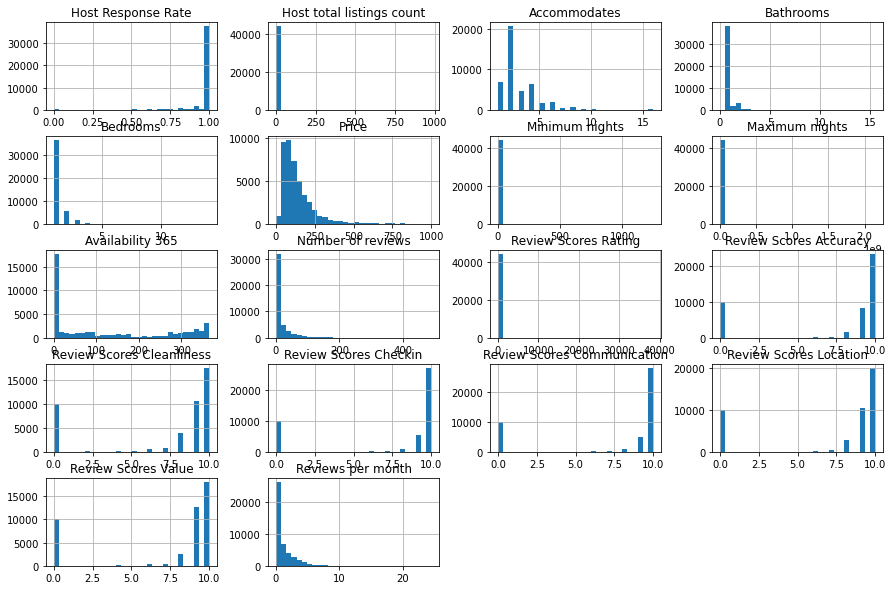

In [15]:
outlier_df = df8[['Host Response Rate','Host total listings count','Accommodates','Bathrooms', 'Bedrooms', 'Price',
            'Minimum nights', 'Maximum nights','Availability 365', 'Number of reviews', 'Review Scores Rating',
            'Review Scores Accuracy', 'Review Scores Cleanliness','Review Scores Checkin', 'Review Scores Communication',
            'Review Scores Location', 'Review Scores Value', 'Reviews per month']]

outlier_df.hist(bins=30, figsize=(15, 10))

Looking at the above histograms, we can classify all columns as skewed. Therefore, we will now classify outliers as values outside the range (Q1 - 1.5 * IQR) , (Q3 + 1.5 * IQR).

In [16]:
lower_bounds = []
upper_bounds = []
maximums = []
columns = outlier_df.columns
outlier_count = []

for col in outlier_df.columns:
    Q3 = np.quantile(outlier_df[col], 0.75)
    Q1 = np.quantile(outlier_df[col], 0.25)
    Max = max(outlier_df[col])
    IQR = Q3 - Q1
    lower_range = Q1 - 1.5 * IQR
    
    if lower_range < 0:
        lower_range = 0
    
    upper_range = Q3 + 1.5 * IQR
    
    outliers = len(outlier_df[(outlier_df[col] > upper_range) | (outlier_df[col] < lower_range)])
    
    lower_bounds.append(lower_range)
    upper_bounds.append(upper_range)
    maximums.append(Max)
    outlier_count.append(outliers)
    
bounds_df = pd.DataFrame(list(zip(columns, lower_bounds, upper_bounds, maximums, outlier_count)), 
                         columns = ["Column","Lower","Upper", "Maximum", "Outlier Count"])

pd.options.display.float_format = '{:.5f}'.format

bounds_df

,Column,Lower,Upper,Maximum,Outlier Count
0,Host Response Rate,1.00000,1.00000,1.00000,7008
1,Host total listings count,0.00000,3.50000,979.00000,3964
2,Accommodates,0.00000,7.00000,16.00000,1285
3,Bathrooms,1.00000,1.00000,15.50000,6121
4,Bedrooms,1.00000,1.00000,14.00000,7849
5,Price,0.00000,326.50000,999.00000,2279
6,Minimum nights,0.00000,8.50000,1250.00000,2875
7,Maximum nights,0.00000,2769.00000,2147483647.00000,65
8,Availability 365,0.00000,695.00000,365.00000,0
9,Number of reviews,0.00000,48.50000,489.00000,5011


#### Column-Specific Outlier Handling

Now we have the lower and upper bounds of our outlier ranges. However, some columns might have outliers - but they're valid data points. Let's take them one by one.

Accommodates: A maximum of 16 is certainly understandale and could very realistically be true. Although some of these rentals that claim to accommodate 16 people are oddly small, that value of 16 still isn't outlandish. Therefore, we'll keep those in.

Bathrooms: Although the maximum of 15.5 is large, that Airbnb has 14 bedrooms. Therefore, it is likely this is just a very large rental.

Bedrooms: The rental with 14 bathrooms is the same one discussed immediately above. Therefore, this value checks out.

Price: Logically, a maximum of $999 makes sense. And since we don't quite have a way to validate or invalidate these prices, we will leave them in.

Minimum nights: The ~3000 rows with a minimum nights value over 8.5 is quite daunting. It is likely that some of the higher values (above 50) are mistakes, as Airbnbs with a minimum night stay of 50 nights is unheard of. Therefore, we will cap the maximum value for this column at 10.

Maximum nights: Similar to minimum nights, it is very likely that these higher values are mistakes. Since Airbnbs do allow very long stays, we will cap the maximum at 365.

Availability 365: The logical maximum for this column is 365. This is the maximum for this column, so these values are valid.

Number of reviews: The upper bound here of ~50 reviews is fairly low. In fact, the maximum of 489 reviews isn't outlandish either. Therefore, we can't classify any of these values as mistakes, so these values will remain.

Review Scores Accuracy - Review Scores Value: The maximum here (according to the data dictionary) is 10. Therefore, these columns are valid.

Reviews per month: While the maximum of 24.53 is impressive, it cannot be ruled out. Therefore, we will keep those values.

In [17]:
# Host Response Rate

# The logical maximum for this value is 1. However, the "outlier" values are actually 1.0, as seen below.
# Therefore, there are no valid outliers in this column.

temp_df = df8[df8['Host Response Rate'] >= 1]

temp_df['Host Response Rate'].value_counts()

1.00000    37020
Name: Host Response Rate, dtype: int64

In [18]:
# Host total listings count

# Here, we can see that there are values in the 100's. However, we do not know if some of these listings being counted are
# owned by this host in other areas. Therefore, this column is difficult to separate into outlier status.

temp_df = df8[df8['Host total listings count'] > 3.50000]

temp_df['Host total listings count'].unique()

array([  4.,  16.,   5.,   6.,  14.,  12.,   8.,   7., 149.,  15.,  10.,
         9.,  11.,  22.,  47.,  13.,  28.,  17.,  23.,  19.,  20.,  31.,
       296., 236.,  24.,  33.,  64., 113.,  39.,  54.,  42.,  94., 218.,
        27., 648.,  18.,  38.,  56.,  49., 316., 979.,  35., 248.,  25.,
       258.,  36.,  21.,  83.,  52., 159.,  85.,  41.])

In [19]:
# Review Scores Rating

# The maximum here (according to the data dictionary) is 100. Those that are above this threshold are wildy so, having
# three occurrences of 38,425. These are likely mistakes, so these rows will be removed.

temp_df = df8[df8['Review Scores Rating'] > 100]

temp_df['Review Scores Rating'].value_counts()

38425    3
Name: Review Scores Rating, dtype: int64

From the research above, we came away with a few transformations to make:
    1. Cap minimum nights at 10.
    2. Cap maximum nights at 365.
    3. Remove three rows with review scores rating above 100

In [20]:
df8.clip(upper=pd.Series({'Minimum nights': 10, 'Maximum nights': 365}), axis=1)
print(df8.shape)
df9 = df8[df8['Review Scores Rating'] <= 100]
print(df9.shape)

(44028, 31)
(44025, 31)


### Duplicate Values

Almost all of the columns in this dataset would logically have duplicate values. The only column that should not have any duplicate values is Listing ID. Therefore, we will compare the length of the dataset with the amount of unique Listing IDs.

In [21]:
print("Number of observations: ", str(len(df9)))
print("Number of unique Listing ID's: ", str(len(df9['Listing ID'].unique())))

Number of observations:  44025
Number of unique Listing ID's:  44025


In [22]:
df9.to_csv(r"C:\Users\ericl\OneDrive\Desktop\SMU\NY_Listings_Validated.csv")

# Simple Statistics

#### Host Response Rate

The response rate among hosts is surprisingly high. In fact, the Q1 value is 1. This means that at least 75% of the hosts in this dataset reply at the maximum rate. This is meaningful because using a variable that has no change for 75%+ of it's values might not be too useful when building a predictive model.

In [23]:
print("Host Response Rate")
print("Min = ", str(min(df9['Host Response Rate'])))
print("Q1  = ", str(np.quantile(df9['Host Response Rate'], .25)))
print("Med = ", str(np.quantile(df9['Host Response Rate'], .5)))
print("Avg = ", str(round((df9['Host Response Rate'].mean()),2)))
print("Q3  = ", str(np.quantile(df9['Host Response Rate'], .75)))
print("Max = ", str(max(df9['Host Response Rate'])))

Host Response Rate
Min =  0.0
Q1  =  1.0
Med =  1.0
Avg =  0.96
Q3  =  1.0
Max =  1.0


#### Accommodates, Bathrooms, Bedrooms

These columns are interesting and meaningful because visualizing their descriptive statistics validates them, to a certain extent. Looking at the means, this is what we would expect. An Airbnb with just over 1 bedroom and 1 bathroom should be expected to accommocate between 2 and 3 people. While decimal points are not realistic for these variables, as you can't accommodate half a person, the pattern of these values across between the minimums and maximums make sense.

Something that might cause concern is if, for example, the minimum values were (Accommodates: 5, Bathrooms: 1, Bedrooms: 1). These obviously aren't logical for an Airbnb, and additional investigation would be required.

The minimum for bathroom might look weird, but the vast majority of the rentals with this value are private or shared rooms that may not have a bathroom reserved for this specific rental.

In [24]:
df9[['Accommodates', 'Bathrooms', 'Bedrooms']].describe()

,Accommodates,Bathrooms,Bedrooms
count,44025.00000,44025.00000,44025.00000
mean,2.81647,1.13232,1.25002
std,1.85331,0.41195,0.62551
min,1.00000,0.00000,1.00000
25%,2.00000,1.00000,1.00000
50%,2.00000,1.00000,1.00000
75%,4.00000,1.00000,1.00000
max,16.00000,15.50000,14.00000


#### Review Scores Rating

These descriptive statistics are meaningful, as they confirm the thought that reviews are dominated by strikingly high or low values. A renter is not likely to grade the Airbnb with such granularity as to assign a value of '84' or '76', but will likely grade on a much less specific scale. Additionally, users are much more likely to grade are the extreme ends of spectrum (0 or 100).

The histogram below depicts these two effects. While the two sides of the spectrum are very obviously the most popular, we do see small spikes at benchmark values such as 20, 40, 60, and 80. This raises another question about different rating systems. Are all of these reviews collected from a 0-100 scale, or is the 1-5 star scale used as well?

Review Scores Rating
Min =  0
Q1  =  79.0
Med =  93.0
Avg =  72.47
Q3  =  98.0
Max =  100


<AxesSubplot:>

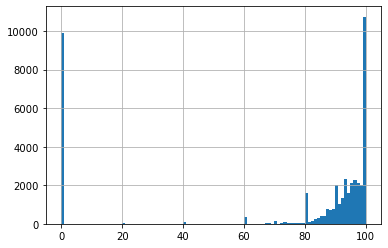

In [25]:
print("Review Scores Rating")
print("Min = ", str(min(df9['Review Scores Rating'])))
print("Q1  = ", str(np.quantile(df9['Review Scores Rating'], .25)))
print("Med = ", str(np.quantile(df9['Review Scores Rating'], .5)))
print("Avg = ", str(round((df9['Review Scores Rating'].mean()),2)))
print("Q3  = ", str(np.quantile(df9['Review Scores Rating'], .75)))
print("Max = ", str(max(df9['Review Scores Rating'])))
df9['Review Scores Rating'].hist(bins=100)

# Visualize Attributes

In [26]:
import seaborn as sns
from matplotlib.pyplot import figure

#df_v = pd.read_csv("NY_Listings_Validated.csv")

df_v = df9
df_v = df_v.drop(df_v.columns[0], axis = 1)

### Correlation

First, in order to reduce the number of continuous variables a correlation matrix will be generated.
From this we can omit anything that has a correlation of 0.5 or greater. Typically this is the cutoff for variables that are highly correlated

In [27]:
corr = df_v.corr()
c1 = corr.abs().unstack()

c1.sort_values(ascending=True, inplace=True)
columns_above_50 = [(col1, col2) for col1, col2 in c1.index if c1[col1,col2] > 0.5 and col1 != col2]
columns_above_50

[('longitude', 'latitude'),
 ('latitude', 'longitude'),
 ('Accommodates', 'Price'),
 ('Price', 'Accommodates'),
 ('Number of reviews', 'Reviews per month'),
 ('Reviews per month', 'Number of reviews'),
 ('Bedrooms', 'Accommodates'),
 ('Accommodates', 'Bedrooms'),
 ('Review Scores Cleanliness', 'Review Scores Location'),
 ('Review Scores Location', 'Review Scores Cleanliness'),
 ('Review Scores Cleanliness', 'Review Scores Checkin'),
 ('Review Scores Checkin', 'Review Scores Cleanliness'),
 ('Review Scores Location', 'Review Scores Rating'),
 ('Review Scores Rating', 'Review Scores Location'),
 ('Review Scores Value', 'Review Scores Cleanliness'),
 ('Review Scores Cleanliness', 'Review Scores Value'),
 ('Review Scores Accuracy', 'Review Scores Location'),
 ('Review Scores Location', 'Review Scores Accuracy'),
 ('Review Scores Communication', 'Review Scores Cleanliness'),
 ('Review Scores Cleanliness', 'Review Scores Communication'),
 ('Review Scores Location', 'Review Scores Communicati

### Removing Highly Correlated or Non Useable Columns

Not surprisingly all of the variables that deal with ratings are highly correlated. Airbnb has a number of different ratings that it uses to classify a rental. These include things like cleanliness, checkin, communication, etc...
Since we are only concerned with <b>Review Scores Rating</b>, and any other review score would be a derivitave of this score, we will remove any column containing 'Review Scores...' and only retain <b>Review Scores Rating</b>.

<b>latitude</b> and <b>longitude</b> together describe a single point so they would be highly correlated. Since we have another location variable, <b>City</b>, we can omit these since they provide redundant information.

<b>Price</b> and <b>Accommodates</b> are highly correlated and so are <b>Accommodates</b> and <b>Bedrooms</b>. In order to simplify the variables we will omit <b>Accomodates</b>.

Lastly from the correlation matrix we can see that <b>Reviews per month</b> and <b>Number of Reviews</b> are highly correlated. Since <b>Number of Reviews</b> contains more information we will retain it and remove <b>Reviews per month</b>.

A couple of other columns will be removed in this step, but not based off of the results of the correlation matrix. <b>Country</b> and <b>State</b> contain only one value, and <b>Street</b> contains incorrect information. Also, <b>Amenities</b> will be removed due to its textual complexity.

> code taken from https://stackoverflow.com/questions/61329582/printing-columns-with-a-correlation-greater-than-80

In [28]:
omit = ['Review Scores Location', 'Review Scores Cleanliness', 'Review Scores Checkin', 'Review Scores Communication', 'Review Scores Accuracy', 'Review Scores Value', 'longitude', 'latitude', 'Accommodates', 'Country', 'State', 'Street', 'Amenities', 'Reviews per month']

dfOmit = df_v.drop(omit, axis=1)

Now that our correlated variables have been removed we are left with a dataframe that looks like the following.

In [29]:
dfOmit.head()

,Host ID,Host Response Rate,Host Is Superhost,Host total listings count,City,Neighbourhood cleansed,Property type,Room type,Bathrooms,Bedrooms,Price,Minimum nights,Maximum nights,Availability 365,Number of reviews,Review Scores Rating
0,16286162,1.00000,False,4.00000,Bronx,Allerton,House,Private room,1.00000,1.00000,43,2,30.00000,276,66,96
1,44260966,1.00000,False,1.00000,Bronx,Soundview,House,Private room,1.00000,1.00000,28,2,31.00000,345,38,89
2,105394139,1.00000,False,16.00000,Bronx,Fordham,House,Private room,3.00000,2.00000,80,3,31.00000,355,18,90
3,104262517,0.70000,False,1.00000,Bronx,Fordham,Apartment,Entire home/apt,1.00000,1.00000,140,2,1125.00000,358,7,85
4,58126473,1.00000,False,1.00000,Bronx,Fordham,Apartment,Private room,1.00000,1.00000,60,1,1125.00000,360,56,95


Now that we have simplified the continous variables we can use PairGrid from seaborn for a quick visualization.

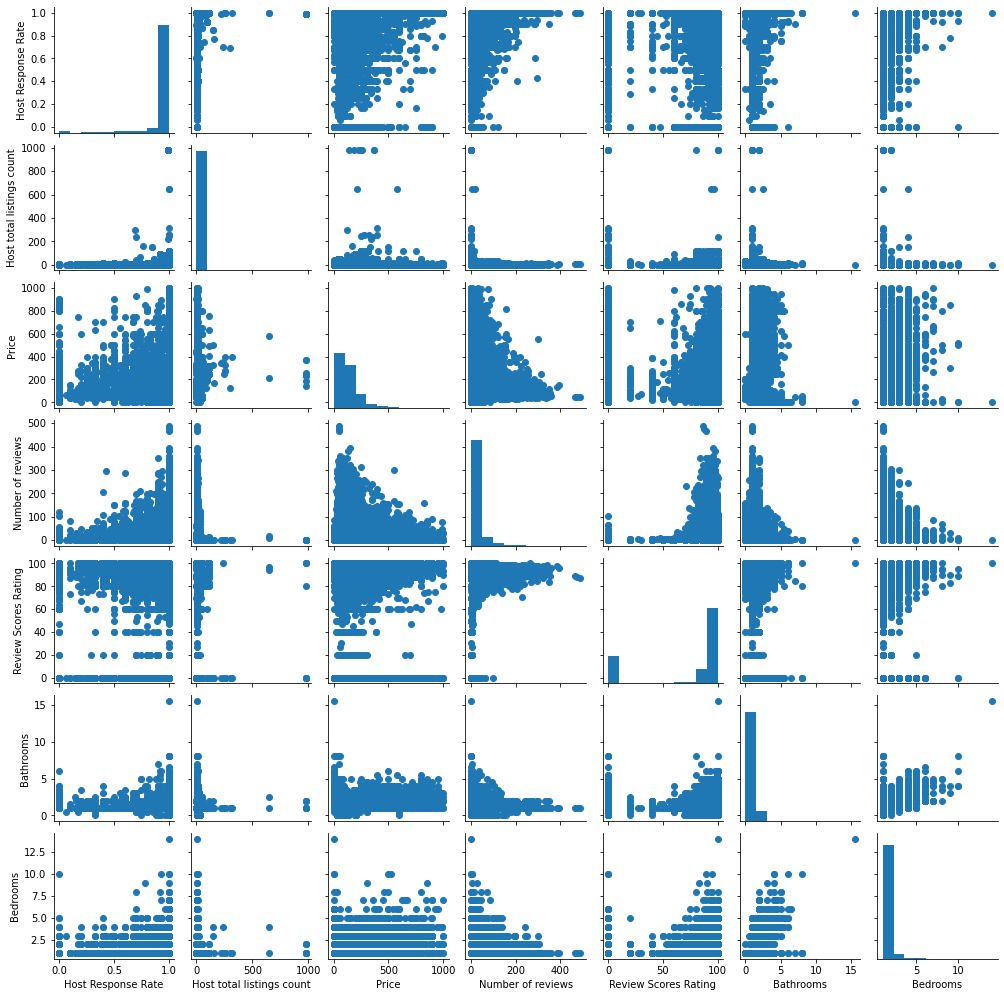

In [30]:
continuous = ['Host Response Rate', 'Host total listings count', 'Price', 'Number of reviews', 'Review Scores Rating', 'Bathrooms', 'Bedrooms']
categorical = ['Host Is Superhost', 'City', 'Neighbourhood cleansed', 'Property type', 'Room type']


graph = sns.PairGrid(dfOmit[continuous])
graph = graph.map_diag(plt.hist)
graph = graph.map_offdiag(plt.scatter)
graph.fig.set_size_inches(14,14)

Very few relationships can be seen from the PairGrid graph concerning <b>Review Scores Rating</b> and any other variable. The only strong linear relationship shown is between <b>Bedrooms</b> and <b>Bathrooms</b>. It may be best to avoid using these two variables together when making predictions.

We will have to look to other methods and the continous variables in order to identify relationships.

# Explore Join Attributes

### Review Scores Rating

In [31]:
from IPython.display import display, HTML

pd.options.display.max_rows = 300
# Puts the scrollbar next to the DataFrame
display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" +
             dfOmit.groupby(['Neighbourhood cleansed']).mean().sort_values(by='Review Scores Rating', ascending=False).to_html() +
             "</div>"))


#dfOmit.groupby(['Neighbourhood cleansed']).mean().sort_values(by='Review Scores Rating', ascending=False)

,Host ID,Host Response Rate,Host Is Superhost,Host total listings count,Bathrooms,Bedrooms,Price,Minimum nights,Maximum nights,Availability 365,Number of reviews,Review Scores Rating
Neighbourhood cleansed,,,,,,,,,,,,
Oakwood,103545877.00000,1.00000,0.00000,1.00000,1.00000,1.00000,100.00000,2.00000,365.00000,0.00000,2.00000,100.00000
Grant City,5949541.00000,1.00000,1.00000,1.00000,1.00000,1.00000,80.00000,3.00000,27.00000,107.00000,18.00000,99.00000
Grymes Hill,44569492.33333,0.90333,0.33333,1.66667,1.00000,1.00000,100.66667,2.00000,754.66667,234.33333,12.00000,98.66667
Neponsit,62608664.00000,1.00000,0.00000,1.00000,1.00000,1.00000,137.00000,2.00000,1125.00000,162.00000,10.00000,98.00000
Hollis Hills,66424949.00000,1.00000,0.50000,1.00000,1.50000,2.00000,267.50000,2.00000,13.50000,265.00000,32.00000,98.00000
Huguenot,82001518.50000,1.00000,0.50000,1.50000,1.00000,1.00000,90.50000,1.00000,26.50000,240.00000,28.50000,98.00000
Castleton Corners,38264992.80000,1.00000,0.40000,2.20000,1.00000,2.20000,140.60000,2.00000,242.40000,258.00000,11.20000,97.80000
Arden Heights,32113778.00000,1.00000,0.00000,4.00000,1.00000,1.00000,37.75000,1.00000,592.50000,245.75000,42.50000,97.50000
Unionport,64425681.50000,0.75000,0.25000,1.00000,1.37500,2.25000,103.75000,2.75000,851.25000,234.50000,12.75000,97.00000


When grouped by Neighbourhood we can see that the average <b>Review Scores Rating</b> has a wide spread and is clearly affected by which Neighborhoud the listing was located in.

As mentioned in the "Business Understanding" section one of the goals is to classify based on whether or not a listing has a rating above 60. In order to generate graphs we will create a column that encodes the ratings variable.

In [32]:
def review_ternary(review):
    if review >= 60:
        return '> 60'
    elif review > 0:
        return '< 60'
    else:
        return 'No Review Given'

dfOmit['Above 60'] = dfOmit['Review Scores Rating'].apply(review_ternary)

dfOmit.head()

,Host ID,Host Response Rate,Host Is Superhost,Host total listings count,City,Neighbourhood cleansed,Property type,Room type,Bathrooms,Bedrooms,Price,Minimum nights,Maximum nights,Availability 365,Number of reviews,Review Scores Rating,Above 60
0,16286162,1.00000,False,4.00000,Bronx,Allerton,House,Private room,1.00000,1.00000,43,2,30.00000,276,66,96,> 60
1,44260966,1.00000,False,1.00000,Bronx,Soundview,House,Private room,1.00000,1.00000,28,2,31.00000,345,38,89,> 60
2,105394139,1.00000,False,16.00000,Bronx,Fordham,House,Private room,3.00000,2.00000,80,3,31.00000,355,18,90,> 60
3,104262517,0.70000,False,1.00000,Bronx,Fordham,Apartment,Entire home/apt,1.00000,1.00000,140,2,1125.00000,358,7,85,> 60
4,58126473,1.00000,False,1.00000,Bronx,Fordham,Apartment,Private room,1.00000,1.00000,60,1,1125.00000,360,56,95,> 60


From here we can explore more relationships. One of the strongest relationships involves number of reviews.

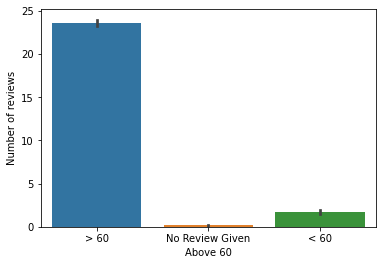

In [33]:
sns.barplot(data = dfOmit.reset_index(), x='Above 60', y='Number of reviews');

As can be seen clearly from the bar chart, properties with an average number of reviews below 3 are more likely to have a Review score less than 60.

In [34]:
pd.crosstab(dfOmit['Above 60'], dfOmit['Room type'], normalize = 'index')

Room type,Entire home/apt,Private room,Shared room
Above 60,,,
< 60,0.33750,0.60000,0.06250
> 60,0.51837,0.45804,0.02358
No Review Given,0.43551,0.53399,0.03050


Next from the cross tab chart we can see that properties that rent the Entire home are more likely to see Ratings above 60 and properties that rent out private or shared rooms are more likely to have Ratings below 60.

### Price

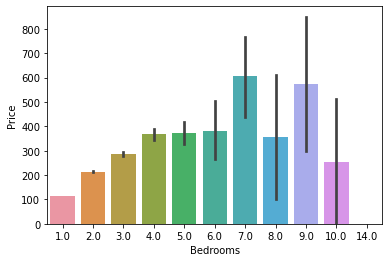

In [35]:
sns.barplot(data = dfOmit.reset_index(), x = 'Bedrooms', y='Price');

The bar plot shows that as the number of bedrooms increases so does price up to a point. Once 7 bedrooms is reached price begins to behave somewhat erradically.

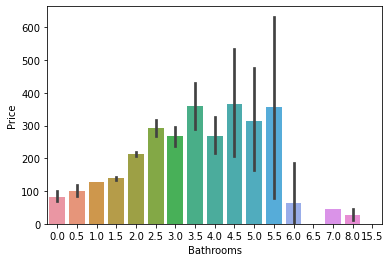

In [36]:
sns.barplot(data = dfOmit.reset_index(), x = 'Bathrooms', y='Price');

<b>Bedrooms</b> and <b>Bathrooms</b> are linearlly related as shown above by the PairGrid graph. This bar graph shows that <b>Bathrooms</b> may be a better predictor of price since it can be a bit more granular.

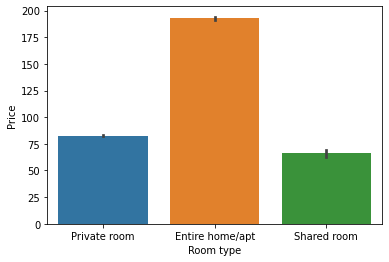

In [37]:
sns.barplot(data = dfOmit.reset_index(), x = 'Room type', y='Price');

Room type also plays a large role in the price of the listing. As can be seen above, hosts that provide the Entire home for rent see significantly higher prices than those that only list a private room or a share room.

# Explore Attributes and Class

### Price v City

It is easy to understand why the location of a listing would relate to its’ price. Factors such as safety, proximity in relation to popular venues and weather are among a slew of reasons why one particular location would have an influence on the price of a listing. We wanted to explore this relationship in our dataset.

In [38]:
CityVPriceDF = df9[["City","Price"]]

In [39]:
CityVPriceDF.groupby("City").describe()

Price                                                 \
                    count      mean       std     min      25%       50%   
City                                                                       
Bronx           788.00000  81.19416  80.30926 0.00000 46.00000  65.00000   
Brooklyn      18380.00000 114.43439  86.51696 0.00000 60.00000  90.00000   
Manhattan     20219.00000 169.43207 124.03203 0.00000 90.00000 140.00000   
Queens         4347.00000  95.47458  76.02341 0.00000 55.00000  75.00000   
Staten Island   291.00000 102.78694  91.69317 0.00000 50.50000  79.00000   

                                   
                    75%       max  
City                               
Bronx          90.00000 862.00000  
Brooklyn      145.00000 999.00000  
Manhattan     200.00000 999.00000  
Queens        110.00000 950.00000  
Staten Island 119.00000 800.00000

In [40]:
CityVPriceDF.groupby("City").median()

,Price
City,
Bronx,65
Brooklyn,90
Manhattan,140
Queens,75
Staten Island,79


Here we have created a subset of our dataset only containing City and Price. We then pull the summary statistics to give us a closer look at how the breakdown of prices for each city. Given the 5 cities we can see across the table of statistics that the data follows a similar pattern. The prices for listings in the Bronx and Queens across the board are lower than the other 3. Of the 3 remaining cities we can see that listings in Manhattan are on average significantly higher. We then were interested to see how the median price of each city would compare to the mean and we can see that it follows the same pattern where the Bronx and Queens are lower while Manhattan is still significantly larger. Although we do not have data on socio economic factors of each listing one could assume that these would play a great role in the difference in pricing across cities. Additional insight for these factors would be worthy of discussion in the future.

### Price v Reviews per Month

The next relationship we wanted to explore was the relationship between the price versus the number of reviews per month. The reason we were interested in this is because there are two schools of thought when it came to reviews. Would a listing with very poor customer satisfaction warrant more reviews than listings with exceptional customer satisfaction? If so, how does this relate to price. If more reviews means worse satisfaction, would this also relate to a lower price? Alternatively, if more reviews means better satisfaction, would this also relate to a higher price? Below we take a look.

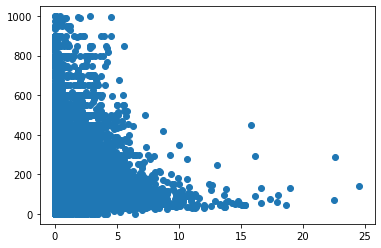

In [41]:
plt.scatter(df9["Reviews per month"], df9["Price"])

What we found is that the number of reviews doesn’t explain the price as well as we had hoped. However, on the lower end of prices we see that there tends to be a wider variation of reviews with the max number of reviews falling at just under the 200 dollar price. 

### Price v Property Type

Lastly, we wanted to look how the price compared against each type of property. Because of the sheer number of properties this investigation was more exploratory as opposed to explanatory. We simply wanted to see how the prices would compare. Again, as we did with the Cities insight, we have included median price of each property type to add additional insight. 

In [42]:
PropVPrice = df9[["Property type","Price"]]
PropVPrice.groupby("Property type").describe()

Price                                          \
                         count      mean       std       min       25%   
Property type                                                            
Apartment          37257.00000 135.82521 101.72949   0.00000  70.00000   
Bed & Breakfast      133.00000 130.13534  92.50960  35.00000  75.00000   
Boat                   8.00000 112.00000  81.06787   0.00000  67.50000   
Boutique hotel        25.00000 169.32000 151.64040   0.00000 109.00000   
Bungalow              19.00000 139.94737  91.85283  40.00000  95.00000   
Cabin                  2.00000 165.00000 120.20815  80.00000 122.50000   
Castle                 1.00000 175.00000       NaN 175.00000 175.00000   
Cave                   1.00000 120.00000       NaN 120.00000 120.00000   
Chalet                 3.00000 150.00000  86.60831  99.00000 100.00000   
Condominium          591.00000 202.97124 157.95766   0.00000  95.00000   
Dorm                  26.00000  72.84615  39.30465  30.00000  56.25000   
Earth House            3.00000 211.66667  58.38093 160.00000 180.00000   
Guest suite           54.00000 129.77778 104.97127  38.00000  75.00000   
Guesthouse            58.00000  81.15517  76.94012   0.00000  37.00000   
Hostel                39.00000  70.66667  41.84013  32.00000  50.50000   
House               3693.00000 120.05470 125.99494   0.00000  50.00000   
In-law                 6.00000 125.66667  46.48297  70.00000  95.00000   
Loft                 876.00000 181.77968 159.69248   0.00000  75.00000   
Other                286.00000 142.80769 121.41037   0.00000  69.00000   
Serviced apartment     9.00000 211.66667 123.38963  70.00000 100.00000   
Timeshare             85.00000 322.30588 154.02350  90.00000 248.00000   
Townhouse            817.00000 165.85312 161.71471   0.00000  65.00000   
Train                  1.00000  67.00000       NaN  67.00000  67.00000   
Treehouse              1.00000  56.00000       NaN  56.00000  56.00000   
Vacation home          9.00000 282.44444 206.91370 135.00000 150.00000   
Villa                 21.00000 125.85714  92.60577  35.00000  59.00000   
Yurt                   1.00000  95.00000       NaN  95.00000  95.00000   

                                                  
                         50%       75%       max  
Property type                                     
Apartment          106.00000 170.00000 999.00000  
Bed & Breakfast    100.00000 150.00000 650.00000  
Boat                92.50000 160.25000 250.00000  
Boutique hotel     150.00000 199.00000 799.00000  
Bungalow           115.00000 155.00000 425.00000  
Cabin              165.00000 207.50000 250.00000  
Castle             175.00000 175.00000 175.00000  
Cave               120.00000 120.00000 120.00000  
Chalet             101.00000 175.50000 250.00000  
Condominium        150.00000 269.00000 878.00000  
Dorm                65.00000  78.75000 238.00000  
Earth House        200.00000 237.50000 275.00000  
Guest suite        100.00000 135.00000 625.00000  
Guesthouse          58.50000  79.00000 375.00000  
Hostel              69.00000  82.00000 280.00000  
House               75.00000 135.00000 995.00000  
In-law             122.00000 146.00000 200.00000  
Loft               132.00000 220.00000 985.00000  
Other              100.00000 170.00000 640.00000  
Serviced apartment 220.00000 300.00000 400.00000  
Timeshare          250.00000 389.00000 799.00000  
Townhouse          103.00000 200.00000 950.00000  
Train               67.00000  67.00000  67.00000  
Treehouse           56.00000  56.00000  56.00000  
Vacation home      199.00000 250.00000 715.00000  
Villa               69.00000 182.00000 350.00000  
Yurt                95.00000  95.00000  95.00000

In [43]:
PropVPrice.groupby("Property type").median()

,Price
Property type,
Apartment,106.00000
Bed & Breakfast,100.00000
Boat,92.50000
Boutique hotel,150.00000
Bungalow,115.00000
Cabin,165.00000
Castle,175.00000
Cave,120.00000
Chalet,101.00000


Although not a lot of explanation can be drawn from this table it is interesting to see how each property type varies as well as how many of each property are available to be rented in New York.

# New Features

Given the extensiveness of our dataset, there was a quite a bit of filtering and removal that was necessary to give us as clean, useful and effective dataset as possible. That being said, there is always features that could be created or added that could provide additional insights that the given data cannot accomplish. 



Starting first with features that we would not be able to create on our own, a feature that shows how many times a particular listing was extended longer than its original booking could be very insightful in terms of its relationship against our target classifications. In the instance that a certain listing has a higher relative occurrence of these extensions it would be fair to pose the assumption that this would relate to having a higher review scores rating (one of our target classifications) for the listing because obviously if a renter is wanting to extend their stay they are more than likely satisfied with the conditions and experience with the property. Another interesting point of view for this feature would be how this would relate to the availability to the property. If a certain property is constantly booked, the number of extensions would be minimal which if following the logic provided previously would suggest a lower customer satisfaction however this would actually be counter intuitive given the fact that the property is constantly being booked. Again however, the availability of the property could actually be more closely related to the price rather than rating given that if a price is cheaper it is more likely to be booked. These are all things that we think would be very interesting to explore and could provide us with a deeper layer of insight when it comes to price and rating.

Now exploring features that could be created given our dataset. One feature that we thought could be used to give us a different outlook on the problem has a whole would be by changing review score rating from a numerical continuous variable to a categorical variable. Our idea would be to view the ratings as a grade scale, where following an identical structure to a school grading system we would have a letter scale. As mentioned earlier, the likelihood of a renter entering a value of such as 73, 81, or 97 would be much less likely than they would be to grade their review with a less specific score. Although using a categorical feature to represent the review score rating might not introduce more success or effectiveness, we believe that this different outlook would be worth exploring and could provide a different lens from which we can view our data through. 